# DeepDTA: Drug-Target Affinity Prediction

This notebook implements a Deep Learning model to predict the binding affinity between drugs (SMILES) and target proteins (Amino Acid Sequences).

**Goal:** Train a CNN-based model on the Davis dataset and export the model for use in a Web Application.

## 1. Environment Setup
Install necessary libraries.

In [1]:
!pip install torch numpy pandas scikit-learn matplotlib seaborn tqdm

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Data Acquisition
Download the Davis dataset files directly from the repository.

In [3]:
DATA_DIR = "data"
BASE_URL = "https://raw.githubusercontent.com/dingyan20/Davis-Dataset-for-DTA-Prediction/main"

def download_file(filename):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    url = f"{BASE_URL}/{filename}"
    filepath = os.path.join(DATA_DIR, filename)

    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        r = requests.get(url)
        with open(filepath, 'wb') as f:
            f.write(r.content)
        print(f"Saved {filename}")
    else:
        print(f"{filename} already exists.")

# Download all 3 required files
download_file("drugs.csv")
download_file("proteins.csv")
download_file("drug_protein_affinity.csv")

Saved drugs.csv
Saved proteins.csv
Saved drug_protein_affinity.csv


## 3. Exploratory Data Analysis (EDA)
Before training, we must understand our data. Key questions:
1. What is the distribution of affinity scores? (Is it balanced?)
2. How long are the SMILES strings and Protein sequences? (Crucial for setting model input shape)
3. Are there missing values?

In [4]:
# Load Dataframes
drugs_df = pd.read_csv(f"{DATA_DIR}/drugs.csv")
prots_df = pd.read_csv(f"{DATA_DIR}/proteins.csv")
affinity_df = pd.read_csv(f"{DATA_DIR}/drug_protein_affinity.csv")

# Set Indices if they exist
if 'Drug_Index' in drugs_df.columns: drugs_df.set_index('Drug_Index', inplace=True)
if 'Protein_Index' in prots_df.columns: prots_df.set_index('Protein_Index', inplace=True)

# Identify correct columns
drug_col = 'Canonical_SMILES' if 'Canonical_SMILES' in drugs_df.columns else drugs_df.columns[0]
prot_col = 'Sequence' if 'Sequence' in prots_df.columns else prots_df.columns[0]

Max Drug Length: 92
Mean Drug Length: 62.8
Max Protein Length: 2549
Mean Protein Length: 768.9


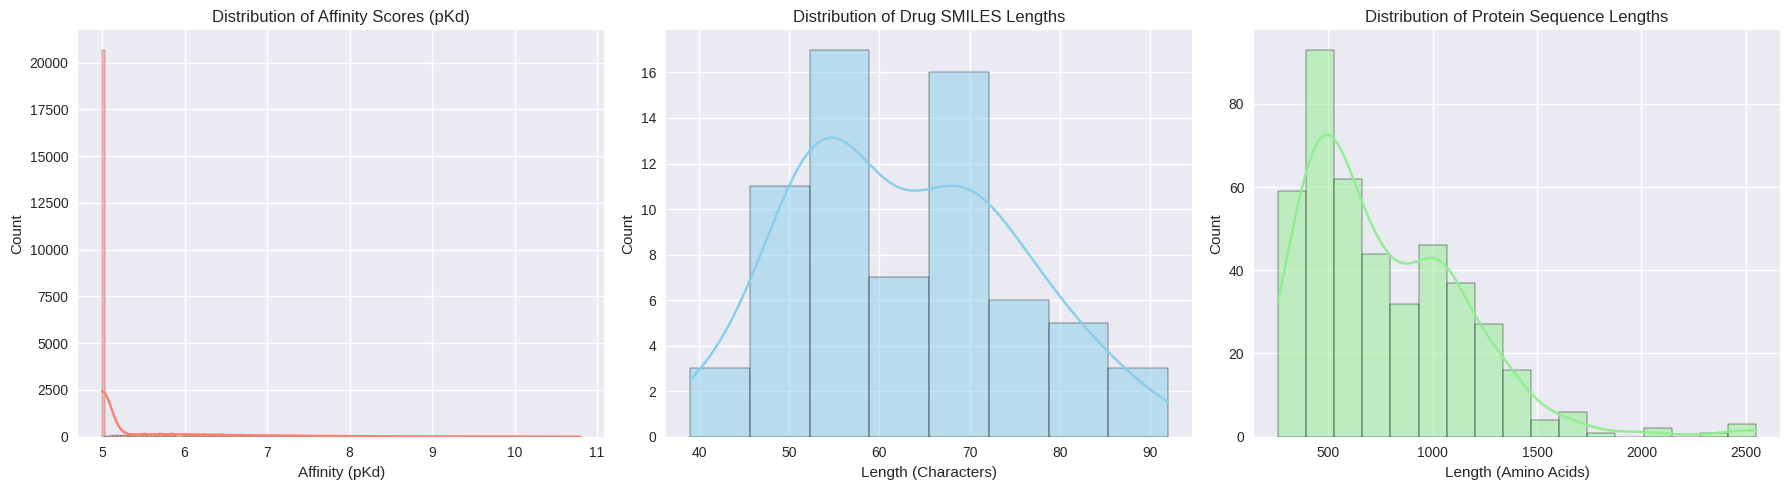

In [5]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Affinity Score Distribution
sns.histplot(affinity_df['Affinity'], kde=True, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Affinity Scores (pKd)')
axes[0].set_xlabel('Affinity (pKd)')

# 2. Drug SMILES Length Distribution
drug_lengths = drugs_df[drug_col].apply(len)
sns.histplot(drug_lengths, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Drug SMILES Lengths')
axes[1].set_xlabel('Length (Characters)')
print(f"Max Drug Length: {drug_lengths.max()}")
print(f"Mean Drug Length: {drug_lengths.mean():.1f}")

# 3. Protein Sequence Length Distribution
prot_lengths = prots_df[prot_col].apply(len)
sns.histplot(prot_lengths, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Protein Sequence Lengths')
axes[2].set_xlabel('Length (Amino Acids)')
print(f"Max Protein Length: {prot_lengths.max()}")
print(f"Mean Protein Length: {prot_lengths.mean():.1f}")

plt.tight_layout()
plt.show()

## 4. Preprocessing & Dataset Class
Based on the analysis above, we set our `max_len` hyperparameters.

In [6]:
# Hyperparameters based on EDA (You can adjust these)
DRUG_MAX_LEN = 100
TARGET_MAX_LEN = 1000

# Helper to build character set
def get_unique_chars(sequences):
    chars = set()
    for seq in sequences:
        chars.update(set(str(seq)))
    return sorted(list(chars))

# Build Vocabs
drug_chars = get_unique_chars(drugs_df[drug_col].values)
target_chars = get_unique_chars(prots_df[prot_col].values)

drug_vocab = {c: i+1 for i, c in enumerate(drug_chars)} # 0 is padding
target_vocab = {c: i+1 for i, c in enumerate(target_chars)}

print(f"Drug Vocab Size: {len(drug_vocab)}")
print(f"Target Vocab Size: {len(target_vocab)}")

Drug Vocab Size: 24
Target Vocab Size: 20


In [7]:
class DTADataset(Dataset):
    def __init__(self, affinity_df, drugs_df, prots_df,
                 drug_vocab, target_vocab,
                 drug_max_len=100, target_max_len=1000):

        self.affinity_df = affinity_df
        self.drugs_df = drugs_df
        self.prots_df = prots_df

        self.drug_vocab = drug_vocab
        self.target_vocab = target_vocab

        self.drug_max_len = drug_max_len
        self.target_max_len = target_max_len

        self.drug_col = 'Canonical_SMILES' if 'Canonical_SMILES' in drugs_df.columns else drugs_df.columns[0]
        self.prot_col = 'Sequence' if 'Sequence' in prots_df.columns else prots_df.columns[0]

    def encode_seq(self, seq, vocab, max_len):
        seq = str(seq)
        indices = [vocab.get(c, 0) for c in seq]
        if len(indices) < max_len:
            indices += [0] * (max_len - len(indices))
        else:
            indices = indices[:max_len]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.affinity_df)

    def __getitem__(self, idx):
        row = self.affinity_df.iloc[idx]
        drug_idx = int(row[0])
        prot_idx = int(row[1])
        affinity = float(row[2])

        # Retrieve raw strings
        smiles = self.drugs_df.loc[drug_idx, self.drug_col]
        sequence = self.prots_df.loc[prot_idx, self.prot_col]

        # Encode
        drug_enc = self.encode_seq(smiles, self.drug_vocab, self.drug_max_len)
        target_enc = self.encode_seq(sequence, self.target_vocab, self.target_max_len)

        return drug_enc, target_enc, torch.tensor(affinity, dtype=torch.float)

# Create Dataset Instance
full_dataset = DTADataset(affinity_df, drugs_df, prots_df, drug_vocab, target_vocab,
                          drug_max_len=DRUG_MAX_LEN, target_max_len=TARGET_MAX_LEN)
print(f"Total Samples: {len(full_dataset)}")

Total Samples: 29444


## 5. Model Architecture (DeepDTA)
We implementation a standard Dual-CNN architecture.
- **Drug Branch**: 3x Conv1d layers
- **Target Branch**: 3x Conv1d layers
- **Combination**: Concatenate outputs -> Fully Connected Layers

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class AttentiveDeepDTA(nn.Module):
    def __init__(self, drug_vocab_size, target_vocab_size,
                 drug_max_len=100, target_max_len=1000,
                 embed_dim=128, n_filters=32, kernel_size=8, attention_heads=4):
        super(AttentiveDeepDTA, self).__init__()
        # Drug Branch
        self.drug_embed = nn.Embedding(drug_vocab_size, embed_dim)
        self.drug_cnn = nn.Sequential(
            nn.Conv1d(embed_dim, n_filters, kernel_size),
            nn.ReLU(),
            nn.Conv1d(n_filters, n_filters*2, kernel_size),
            nn.ReLU(),
            nn.Conv1d(n_filters*2, n_filters*3, kernel_size),
            nn.ReLU(),
        )
        self.drug_attention = nn.MultiheadAttention(embed_dim=n_filters*3, num_heads=attention_heads, batch_first=True)

        # Target Branch
        self.target_embed = nn.Embedding(target_vocab_size, embed_dim)
        self.target_cnn = nn.Sequential(
            nn.Conv1d(embed_dim, n_filters, kernel_size),
            nn.ReLU(),
            nn.Conv1d(n_filters, n_filters*2, kernel_size),
            nn.ReLU(),
            nn.Conv1d(n_filters*2, n_filters*3, kernel_size),
            nn.ReLU(),
        )
        self.target_attention = nn.MultiheadAttention(embed_dim=n_filters*3, num_heads=attention_heads, batch_first=True)

        # FC
        self.fc = nn.Sequential(
            nn.Linear(n_filters*3 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, drug_seq, target_seq):
        x_drug = self.drug_embed(drug_seq).permute(0, 2, 1)
        x_target = self.target_embed(target_seq).permute(0, 2, 1)

        x_drug = self.drug_cnn(x_drug)
        x_target = self.target_cnn(x_target)

        x_drug = x_drug.permute(0, 2, 1)
        x_target = x_target.permute(0, 2, 1)

        x_drug_att, _ = self.drug_attention(x_drug, x_drug, x_drug)
        x_target_att, _ = self.target_attention(x_target, x_target, x_target)

        x_drug = x_drug_att.max(dim=1)[0]
        x_target = x_target_att.max(dim=1)[0]

        x = torch.cat((x_drug, x_target), dim=1)
        return self.fc(x)

## 6. Training Setup
Define hyperparameters, split dataset, and initialize model.

In [ ]:
# Config
BATCH_SIZE = 64  
LEARNING_RATE = 0.001
EPOCHS = 20
TRAIN_SPLIT = 0.8

# Split
train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Init Model
drug_vocab_size = len(drug_vocab) + 1
target_vocab_size = len(target_vocab) + 1

model = AttentiveDeepDTA(drug_vocab_size, target_vocab_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

## 7. Training Loop
Train the model and monitor Loss (MSE).

In [12]:
train_losses = []

print(f"Starting training for {EPOCHS} epochs on {DEVICE}...")

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")

    for i, (drug, target, affinity) in progress_bar:
        drug = drug.to(DEVICE)
        target = target.to(DEVICE)
        affinity = affinity.to(DEVICE).float()

        optimizer.zero_grad()
        output = model(drug, target).squeeze()
        loss = criterion(output, affinity)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss (MSE): {avg_loss:.4f}")

Starting training for 20 epochs on cuda...


Epoch 1:   0%|          | 0/369 [00:00<?, ?it/s]/tmp/ipython-input-38375312.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drug_idx = int(row[0])
/tmp/ipython-input-38375312.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prot_idx = int(row[1])
/tmp/ipython-input-38375312.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  affinity = float(row[2])
Epoch 1: 100%|██████████| 369/369 [00:54<00:00,  6.74it/s, loss=0.24]


Epoch 1 Average Loss (MSE): 2.6917


Epoch 2: 100%|██████████| 369/369 [00:55<00:00,  6.69it/s, loss=0.0501]


Epoch 2 Average Loss (MSE): 0.6483


Epoch 3: 100%|██████████| 369/369 [00:54<00:00,  6.82it/s, loss=0.00453]


Epoch 3 Average Loss (MSE): 0.6006


Epoch 4: 100%|██████████| 369/369 [00:54<00:00,  6.81it/s, loss=0.102]


Epoch 4 Average Loss (MSE): 0.5937


Epoch 5: 100%|██████████| 369/369 [00:54<00:00,  6.79it/s, loss=0.721]


Epoch 5 Average Loss (MSE): 0.5642


Epoch 6: 100%|██████████| 369/369 [00:54<00:00,  6.83it/s, loss=0.268]


Epoch 6 Average Loss (MSE): 0.5519


Epoch 7: 100%|██████████| 369/369 [00:54<00:00,  6.82it/s, loss=0.104]


Epoch 7 Average Loss (MSE): 0.5101


Epoch 8: 100%|██████████| 369/369 [00:54<00:00,  6.81it/s, loss=0.414]


Epoch 8 Average Loss (MSE): 0.5043


Epoch 9: 100%|██████████| 369/369 [00:53<00:00,  6.84it/s, loss=1.24]


Epoch 9 Average Loss (MSE): 0.5087


Epoch 10: 100%|██████████| 369/369 [00:54<00:00,  6.82it/s, loss=0.528]


Epoch 10 Average Loss (MSE): 0.4962


Epoch 11: 100%|██████████| 369/369 [00:54<00:00,  6.82it/s, loss=0.0286]


Epoch 11 Average Loss (MSE): 0.4938


Epoch 12: 100%|██████████| 369/369 [00:54<00:00,  6.83it/s, loss=2.32]


Epoch 12 Average Loss (MSE): 0.4862


Epoch 13: 100%|██████████| 369/369 [00:53<00:00,  6.84it/s, loss=0.0161]


Epoch 13 Average Loss (MSE): 0.4882


Epoch 14: 100%|██████████| 369/369 [00:54<00:00,  6.80it/s, loss=1.05]


Epoch 14 Average Loss (MSE): 0.4974


Epoch 15: 100%|██████████| 369/369 [00:53<00:00,  6.84it/s, loss=0.682]


Epoch 15 Average Loss (MSE): 0.4989


Epoch 16: 100%|██████████| 369/369 [00:54<00:00,  6.82it/s, loss=0.249]


Epoch 16 Average Loss (MSE): 0.4758


Epoch 17: 100%|██████████| 369/369 [00:53<00:00,  6.84it/s, loss=0.0524]


Epoch 17 Average Loss (MSE): 0.4682


Epoch 18: 100%|██████████| 369/369 [00:53<00:00,  6.84it/s, loss=2.31]


Epoch 18 Average Loss (MSE): 0.4695


Epoch 19: 100%|██████████| 369/369 [00:53<00:00,  6.85it/s, loss=2.97]


Epoch 19 Average Loss (MSE): 0.4733


Epoch 20: 100%|██████████| 369/369 [00:54<00:00,  6.82it/s, loss=0.00277]

Epoch 20 Average Loss (MSE): 0.4466


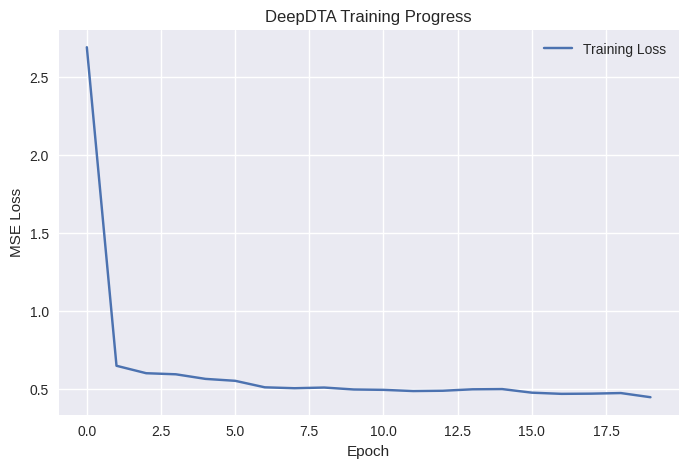

In [13]:
# Plot Training Curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('DeepDTA Training Progress')
plt.legend()
plt.show()

## 8. Export Artifacts
We need to save the `state_dict` (weights) and the `vocabularies` (mappings).
These two files are required by the backend to make predictions.

In [14]:
import pickle

# 1. Save Model
torch.save(model.state_dict(), "deepdta_model.pth")
print("Saved: deepdta_model.pth")

# 2. Save Vocabs
with open("vocabs.pkl", "wb") as f:
    pickle.dump({
        "drug_vocab": drug_vocab,
        "target_vocab": target_vocab,
        "drug_max_len": DRUG_MAX_LEN,      # Saved for consistency
        "target_max_len": TARGET_MAX_LEN
    }, f)
print("Saved: vocabs.pkl")

Saved: deepdta_model.pth
Saved: vocabs.pkl


In [15]:
model.eval()
print("\n--- Test Predictions ---")
with torch.no_grad():
    for i in range(50):
        # random sample
        idx = np.random.randint(0, len(test_dataset))
        drug, target, affinity = test_dataset[idx]

        # Add batch dimension
        d = drug.unsqueeze(0).to(DEVICE)
        t = target.unsqueeze(0).to(DEVICE)

        pred = model(d, t).item()

        print(f"Sample {idx}:")
        print(f"  Actual:    {affinity.item():.4f}")
        print(f"  Predicted: {pred:.4f}")
        print("-" * 20)


--- Test Predictions ---
Sample 4465:
  Actual:    7.5376
  Predicted: 5.8719
--------------------
Sample 26:
  Actual:    5.0000
  Predicted: 4.6863
--------------------
Sample 158:
  Actual:    5.0000
  Predicted: 4.9107
--------------------
Sample 5143:
  Actual:    5.0000
  Predicted: 4.6139
--------------------
Sample 282:
  Actual:    5.0000
  Predicted: 4.9833
--------------------
Sample 5669:
  Actual:    5.0000
  Predicted: 4.8482
--------------------
Sample 4801:
  Actual:    5.0000
  Predicted: 4.8844
--------------------
Sample 5316:
  Actual:    5.0000
  Predicted: 4.7593
--------------------
Sample 34:
  Actual:    5.0000
  Predicted: 5.0339
--------------------
Sample 5097:
  Actual:    8.4437
  Predicted: 7.1849
--------------------
Sample 681:
  Actual:    5.0000
  Predicted: 4.7716
--------------------
Sample 149:
  Actual:    5.0000
  Predicted: 4.8244
--------------------
Sample 1869:
  Actual:    5.0000
  Predicted: 4.7529
--------------------
Sample 872:
  Actual

/tmp/ipython-input-38375312.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drug_idx = int(row[0])
/tmp/ipython-input-38375312.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prot_idx = int(row[1])
/tmp/ipython-input-38375312.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  affinity = float(row[2])


Predicting:   0%|          | 0/93 [00:00<?, ?it/s]/tmp/ipython-input-38375312.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drug_idx = int(row[0])
/tmp/ipython-input-38375312.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prot_idx = int(row[1])
/tmp/ipython-input-38375312.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  affinity = float(row[2])
Predicting: 100%|██████████| 93/93 [00:06<00:00, 15.49it/s]


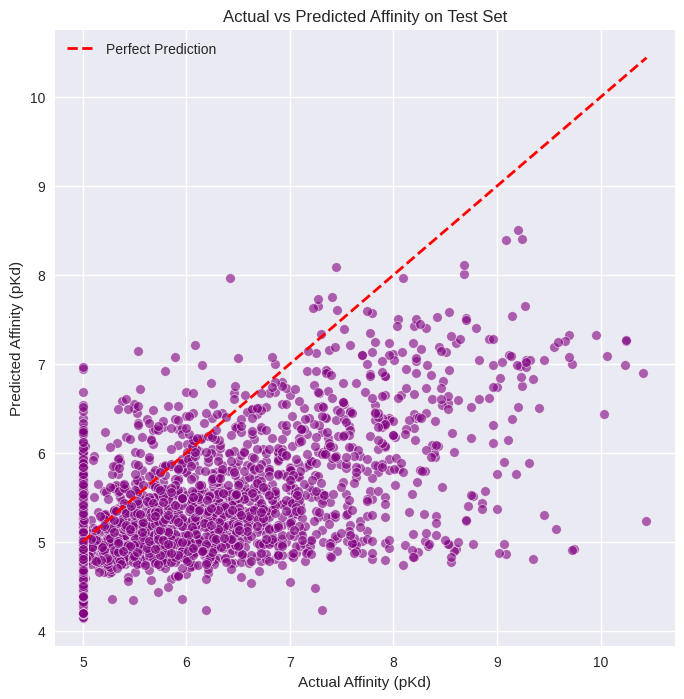


--- Evaluation Metrics ---
Pearson Correlation:  0.6861
Spearman Correlation: 0.5688


In [16]:
model.eval()
y_true = []
y_pred = []

print("Collecting predictions for all test samples...")
with torch.no_grad():
    for drug, target, affinity in tqdm(test_loader, desc="Predicting"):
        drug = drug.to(DEVICE)
        target = target.to(DEVICE)

        output = model(drug, target).squeeze()

        # Handle predictions
        if output.ndim == 0:
            y_pred.append(output.item())
            y_true.append(affinity.item())
        else:
            y_pred.extend(output.cpu().numpy())
            y_true.extend(affinity.cpu().numpy())

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color='purple')
# Perfect prediction line
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Affinity (pKd)')
plt.ylabel('Predicted Affinity (pKd)')
plt.title('Actual vs Predicted Affinity on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Correlation Metrics
from scipy.stats import pearsonr, spearmanr
p_corr, _ = pearsonr(y_true, y_pred)
s_corr, _ = spearmanr(y_true, y_pred)

print(f"\n--- Evaluation Metrics ---")
print(f"Pearson Correlation:  {p_corr:.4f}")
print(f"Spearman Correlation: {s_corr:.4f}")